In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models

### Constantes

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

### Funções auxiliares

In [3]:
def central_crop(image):
  s = tf.shape(image)
  L = tf.reduce_min((s[0], s[1]))
  x1 = (s[1] - L ) // 2
  y1 = (s[0] - L ) // 2

  return tf.image.resize(image[y1: y1+L, x1: x1+L], (IMAGE_SIZE, IMAGE_SIZE))


def preprocess_aug_mobileNet(image, label):

  image = central_crop(image) # Crop da imagem

  image = tf.cast(image, tf.uint8)
  image = tf.image.random_brightness(image, max_delta=0.3) # Brilho random
  #image = tf.image.random_contrast(image, lower=1, upper=1.5) # Contrast random

  image = tf.cast(image, tf.float32)
  if (tf.random.uniform((), minval=0, maxval=1) < 0.1): # Conversão para gray scale random
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

  image = tf.image.random_flip_left_right(image) # Random flip vertical
  image = tf.image.random_flip_up_down(image) # Random flip horizontal

  image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess MobileNetV2

  return image, tf.one_hot(label, depth = ds_info.features['label'].num_classes) # Retorno da imagem e classes no formato one hot encoding



def preprocess_mobileNet(image, label):

  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # Redimensionamento da imagem
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # Preprocess MobileNetV2

  return image, tf.one_hot(label, depth = ds_info.features['label'].num_classes) # Retorno da imagem e classes no formato one hot encoding



def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(accuracy))

  plt.plot(epochs, loss, color='blue', linestyle='--', label='training_loss')
  plt.plot(epochs, accuracy, color='blue', label='training_accuracy')
  plt.plot(epochs, val_loss, color='orange', linestyle='--', label='validation_loss')
  plt.plot(epochs, val_accuracy, color='orange', label='validation_accuracy')
  plt.axis([0,NUM_EPOCHS,0,2])
  plt.title("Train and Test Evolution")
  plt.xlabel("Epochs")
  plt.legend()

## Load Dataset

In [4]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    name = 'oxford_iiit_pet',
    split = ["train[:80%]", "train[80%:]", "test"],
    with_info = True,
    as_supervised = True
)

### Plot images for each class

In [5]:
num_images_per_class = 5

class_names = ds_info.features['label'].names
num_classes = len(class_names)

class_images = {i: [] for i in range(num_classes)}

def collect_images(image, label):
  if len(class_images[label]) < num_images_per_class:
      class_images[label].append(image)
  return len(class_images[label]) >= num_images_per_class

for image, label in tfds.as_numpy(ds_train):
    if all(len(imgs) >= num_images_per_class for imgs in class_images.values()):
        break
    collect_images(image, label)

plt.figure(figsize=(20, num_classes * 3))

for class_idx, images in class_images.items():
    for i in range(num_images_per_class):
        plt.subplot(num_classes, num_images_per_class, class_idx * num_images_per_class + i + 1)
        plt.imshow(images[i])
        plt.title(class_names[class_idx])
        plt.axis('off')

plt.savefig('./class_images.png')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Prepare datasets

In [6]:
ds_train = ds_train.map(preprocess_aug_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.map(preprocess_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_mobileNet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Plot first images of N batches

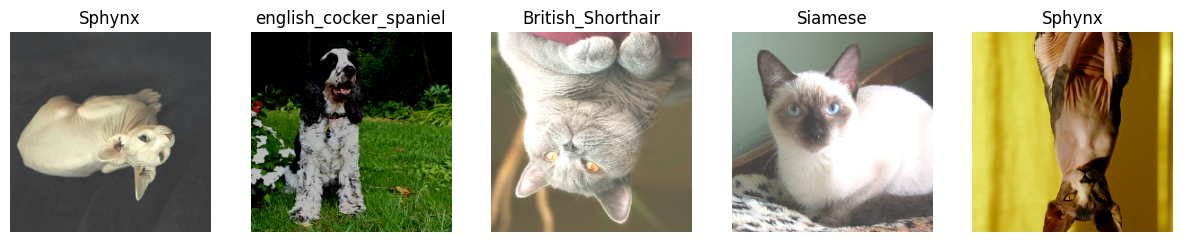

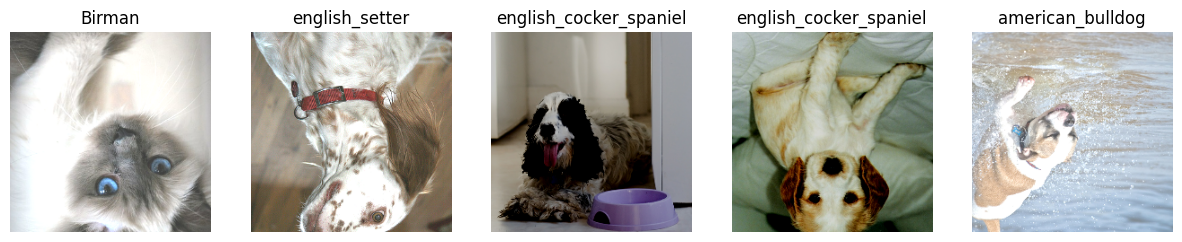

In [7]:
nBatches = 2
firstNImages = 5
for Img, lab in ds_train.take(nBatches):
  plt.figure(figsize=(15, 3))
  for i in range(firstNImages):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title(ds_info.features['label'].names[np.argmax(lab[i])])
    A = (Img[i].numpy() +1)/2 *255.
    plt.imshow(A.astype('uint8'))
    plt.axis('off')
  print("\n\n")


____________________________

# Prepare model using Mobile Net V2 as base model

In [8]:
def build_mobilenetv2_model():
  base_model = tf.keras.applications.MobileNetV2(
      input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
      include_top = False,
      weights = "imagenet"
  )

  base_model.trainable = False

  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(ds_info.features['label'].num_classes, activation = 'softmax')
  ])

  return model

In [9]:
mobilenetv2_model = build_mobilenetv2_model()
mobilenetv2_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [10]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 37)                4773      
                                                                 
Total params: 2426725 (9.26 MB)
Trainable params: 168741

_____________________________________

## Fit Model

In [11]:
%%time

import os

NUM_EPOCHS = 30
STEPS_PER_EPOCH = len(ds_train)
VALIDATION_STEPS = len(ds_valid)

best_model = os.path.join('./models/', 'mult_model.keras')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              min_delta=0.001,
                                              restore_best_weights=True)

save_best_model = tf.keras.callbacks.ModelCheckpoint(best_model,
                                             monitor='val_loss',
                                             save_best_only=True)

mobileNet_history = mobilenetv2_model.fit(ds_train,
                                        epochs= NUM_EPOCHS,
                                        steps_per_epoch = STEPS_PER_EPOCH,
                                        validation_data = ds_valid,
                                        validation_steps = VALIDATION_STEPS,
                                        callbacks=[early_stop, save_best_model]
                                        )

Epoch 1/30
92/92 [==============================] - 212s 2s/step - loss: 2.6540 - accuracy: 0.2945 - val_loss: 1.0375 - val_accuracy: 0.7840
Epoch 2/30
92/92 [==============================] - 200s 2s/step - loss: 1.4436 - accuracy: 0.5781 - val_loss: 0.5443 - val_accuracy: 0.8438
Epoch 3/30
92/92 [==============================] - 211s 2s/step - loss: 1.0948 - accuracy: 0.6844 - val_loss: 0.4308 - val_accuracy: 0.8614
Epoch 4/30
92/92 [==============================] - 201s 2s/step - loss: 0.9623 - accuracy: 0.7028 - val_loss: 0.3816 - val_accuracy: 0.8764
Epoch 5/30
92/92 [==============================] - 196s 2s/step - loss: 0.8474 - accuracy: 0.7429 - val_loss: 0.3718 - val_accuracy: 0.8886
Epoch 6/30
92/92 [==============================] - 239s 3s/step - loss: 0.8232 - accuracy: 0.7442 - val_loss: 0.3602 - val_accuracy: 0.8791
Epoch 7/30
92/92 [==============================] - 193s 2s/step - loss: 0.7344 - accuracy: 0.7728 - val_loss: 0.3486 - val_accuracy: 0.8913
Epoch 8/30
92

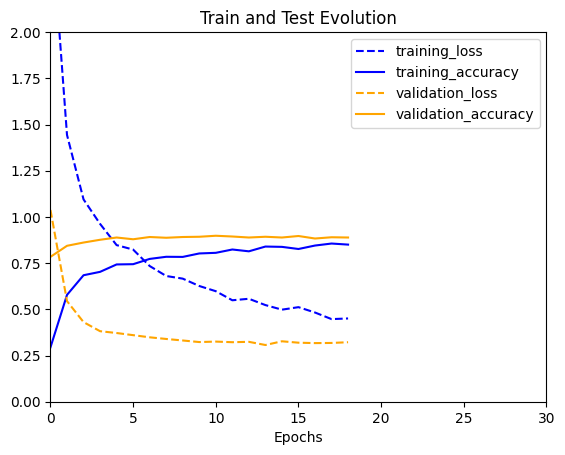

In [12]:
plot_loss_curves(mobileNet_history)

______________
## Evaluate Model

In [13]:
%%time
from sklearn.metrics import classification_report, confusion_matrix

y_pred = mobilenetv2_model.predict(ds_test)

115/115 [==============================] - 191s 2s/step
CPU times: user 3min 23s, sys: 1min 38s, total: 5min 1s
Wall time: 3min 10s


In [14]:
y_pred_classes = np.argmax(y_pred, axis=1)
images = np.concatenate([x for x, y in ds_test], axis=0)
y_true_one_hot = np.concatenate([y for x, y in ds_test], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)

Total number of errors: 440 


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.78      0.93      0.85        98
          american_bulldog       0.66      0.92      0.77       100
 american_pit_bull_terrier       0.83      0.53      0.65       100
              basset_hound       0.92      0.92      0.92       100
                    beagle       0.96      0.86      0.91       100
                    Bengal       0.75      0.83      0.79       100
                    Birman       0.87      0.67      0.76       100
                    Bombay       0.89      0.84      0.87        88
                     boxer       0.84      0.90      0.87        99
         British_Shorthair       0.83      0.64      0.72       100
                 chihuahua       0.91      0.74      0.82       100
              Egyptian_Mau       0.85      0.85      0.85        97
    english_cocker_spaniel       0.97      0.87      0.92   

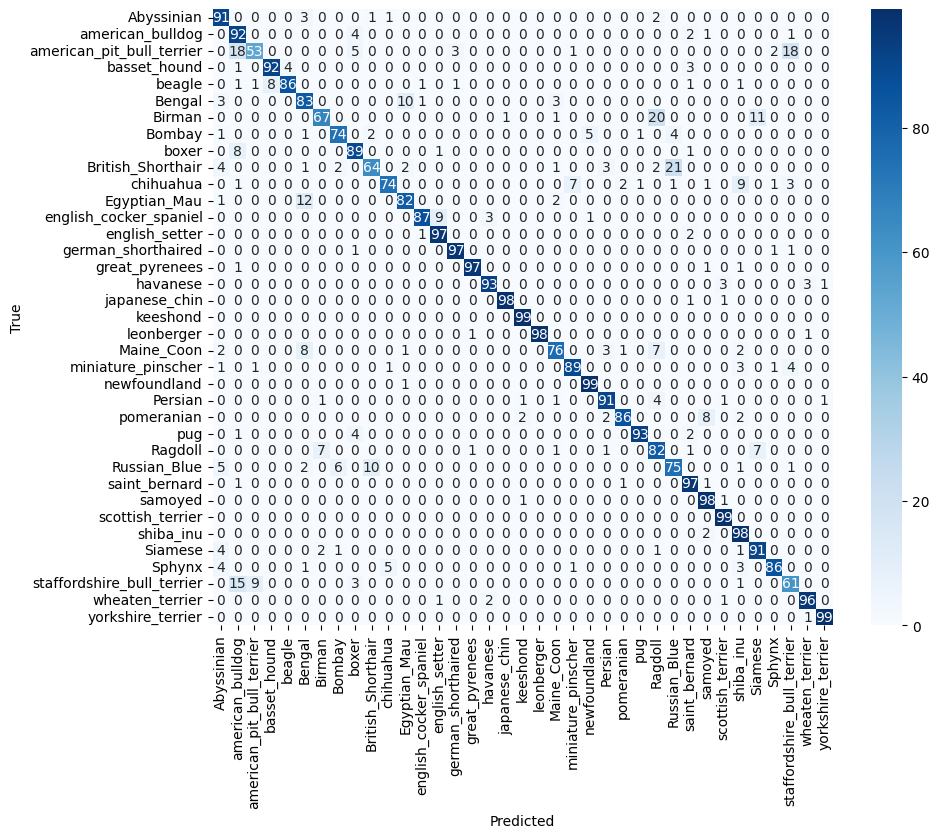

In [15]:
print('Total number of errors:', np.sum(y_true != y_pred_classes), "\n\n")

# Classification report for precision, recall, and F1-score
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names), "\n\n")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Show a few examples of miss classificated images

In [16]:
misclassified_indices = np.where(y_true != y_pred_classes)[0]

# Plot misclassified images
num_images_to_plot = 20
plt.figure(figsize=(20, 10))
for i, idx in enumerate(misclassified_indices[:num_images_to_plot]):
  plt.subplot(4, num_images_to_plot//4, i+1)
  image = ((images[idx] + 1)/2 * 255).astype(np.uint8)
  plt.imshow(image)
  plt.title(f'True: {class_names[y_true[idx]]}\n Pred: {class_names[y_pred_classes[idx]]}')
  plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.